# Machine Learning Project
# Kansas City Crime Data Deep Dive

### Import Dependancies

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
import pandas as pd
from pandas import datetime
from dateutil import parser
from scipy import stats
import os

### Obtain KCMO crime data (Raw data came from data.kcmo.org)

In [2]:
file_name = os.path.join('Resources', 'KCPD_Crime_Data_2017.csv')
kc_crime = pd.read_csv(file_name)
# kc_crime.Reported_Date = pd.to_datetime(kc_crime.Reported_Date)
kc_crime.reset_index()
kc_crime.head()

,Report_No,Reported_Date,Reported_Time,From_Date,From_Time,To_Date,To_Time,Offense,IBRS,Description,...,Rep_Dist,Area,DVFlag,Invl_No,Involvement,Race,Sex,Age,Firearm Used Flag,Location
0,100080848,5/28/2017,3:44,5/28/2017,2:00,NaN,NaN,1352,280,Stolen Property OFFE,...,PJ3255,CPD,U,1,VIC,W,F,29.0,N,"4000 MILL ST\nKANSAS CITY 64111\n(39.053635, -..."
1,120046817,11/21/2017,13:30,11/20/2017,9:00,NaN,NaN,101,09A,HOMICIDE/Non Neglige,...,PJ1029,CPD,U,1,SUS,B,M,NaN,Y,"1100 LOCUST ST\nKANSAS CITY 64105\n(39.10091, ..."
2,120046817,11/21/2017,13:30,11/20/2017,9:00,NaN,NaN,101,09A,HOMICIDE/Non Neglige,...,PJ1029,CPD,N,1,VIC,B,F,69.0,Y,"1100 LOCUST ST\nKANSAS CITY 64105\n(39.10091, ..."
3,120085080,4/27/2017,11:12,NaN,NaN,NaN,NaN,201,11A,Rape,...,NaN,NaN,U,1,VIC,B,F,21.0,N,99999\n
4,120085080,4/27/2017,11:12,NaN,NaN,NaN,NaN,201,11A,Rape,...,NaN,NaN,U,1,SUS,B,M,52.0,N,99999\n


### Change time to datetime and extract hour

In [3]:
kc_crime['Reported_Hour'] = pd.to_datetime(kc_crime['Reported_Time'])

In [4]:
kc_crime["Reported_Hour"] = kc_crime["Reported_Hour"].dt.floor('h')

In [5]:
kc_crime['Test'] = kc_crime['Reported_Hour'].dt.hour

In [6]:
kc_crime.head()

,Report_No,Reported_Date,Reported_Time,From_Date,From_Time,To_Date,To_Time,Offense,IBRS,Description,...,DVFlag,Invl_No,Involvement,Race,Sex,Age,Firearm Used Flag,Location,Reported_Hour,Test
0,100080848,5/28/2017,3:44,5/28/2017,2:00,NaN,NaN,1352,280,Stolen Property OFFE,...,U,1,VIC,W,F,29.0,N,"4000 MILL ST\nKANSAS CITY 64111\n(39.053635, -...",2018-06-05 03:00:00,3
1,120046817,11/21/2017,13:30,11/20/2017,9:00,NaN,NaN,101,09A,HOMICIDE/Non Neglige,...,U,1,SUS,B,M,NaN,Y,"1100 LOCUST ST\nKANSAS CITY 64105\n(39.10091, ...",2018-06-05 13:00:00,13
2,120046817,11/21/2017,13:30,11/20/2017,9:00,NaN,NaN,101,09A,HOMICIDE/Non Neglige,...,N,1,VIC,B,F,69.0,Y,"1100 LOCUST ST\nKANSAS CITY 64105\n(39.10091, ...",2018-06-05 13:00:00,13
3,120085080,4/27/2017,11:12,NaN,NaN,NaN,NaN,201,11A,Rape,...,U,1,VIC,B,F,21.0,N,99999\n,2018-06-05 11:00:00,11
4,120085080,4/27/2017,11:12,NaN,NaN,NaN,NaN,201,11A,Rape,...,U,1,SUS,B,M,52.0,N,99999\n,2018-06-05 11:00:00,11


### Rename & drop columns

In [7]:
kc_crime.rename(columns={'Zip Code':'zip_code'}, inplace=True)
kc_crime_dropped_columns = kc_crime.drop(['Reported_Hour', 'Reported_Time', 'To_Date', 'From_Date', 'To_Time', 'From_Time',
                          'Offense', 'IBRS', 'Rep_Dist', 'Area', 'Beat', 'Address'], axis=1)

### Filter for male and female victims age 90 and under in KCMO

In [8]:
kc_crime_clean_zips = kc_crime_dropped_columns[kc_crime_dropped_columns.zip_code != 99999]
only_kc_crime = kc_crime_clean_zips[kc_crime_clean_zips.City.str.contains("KANSAS CITY") == True]

victims = only_kc_crime[only_kc_crime.Involvement.str.contains("VIC") == True]

victims_no_nans = victims[victims.Sex.str.contains("NaN") == False]
male_female_victims_kcmo = victims_no_nans[victims_no_nans.Sex.str.contains("U") == False]

kc_crime_real_ages = male_female_victims_kcmo[male_female_victims_kcmo['Age'] < 91]

### Copy kc_crime_real_ages and separate "Location" into 3 columns

In [9]:
kc_crime_real_ages_copy = kc_crime_real_ages.copy()
kc_crime_real_ages_copy.head(1)

,Report_No,Reported_Date,Description,City,zip_code,DVFlag,Invl_No,Involvement,Race,Sex,Age,Firearm Used Flag,Location,Test
0,100080848,5/28/2017,Stolen Property OFFE,KANSAS CITY,64111,U,1,VIC,W,F,29.0,N,"4000 MILL ST\nKANSAS CITY 64111\n(39.053635, -...",3


# Split out geo data

In [10]:
location_only = kc_crime_real_ages_copy['Location'].str[0:-1].str.split('\n', expand=True)
location_only.columns = ("address", "city_zip", "geo")
location_only.head(1)

,address,city_zip,geo
0,4000 MILL ST,KANSAS CITY 64111,"(39.053635, -94.595998"


### Parsing out latitude and longitude

In [11]:
location_only['geo'] = location_only['geo'].str[1:]
geo_split = location_only['geo'].str[0:].str.split(', ', expand=True)
geo_split.columns = ("Latitude", "Longitude")
geo_split.head(1)

,Latitude,Longitude
0,39.053635,-94.595998


In [12]:
kc_crime_real_ages_copy.count()

Report_No            43032
Reported_Date        43032
Description          43032
City                 43032
zip_code             43032
DVFlag               43032
Invl_No              43032
Involvement          43032
Race                 43032
Sex                  43032
Age                  43032
Firearm Used Flag    43032
Location             43032
Test                 43032
dtype: int64

In [13]:
geo_split.count()

Latitude     32283
Longitude    32283
dtype: int64

In [14]:
kcmo_crime_with_nans = pd.concat([kc_crime_real_ages_copy, geo_split], axis=1)
kcmo_crime_with_nans.head(1)

,Report_No,Reported_Date,Description,City,zip_code,DVFlag,Invl_No,Involvement,Race,Sex,Age,Firearm Used Flag,Location,Test,Latitude,Longitude
0,100080848,5/28/2017,Stolen Property OFFE,KANSAS CITY,64111,U,1,VIC,W,F,29.0,N,"4000 MILL ST\nKANSAS CITY 64111\n(39.053635, -...",3,39.053635,-94.595998


In [15]:
kcmo_crime_with_nans.count()

Report_No            43032
Reported_Date        43032
Description          43032
City                 43032
zip_code             43032
DVFlag               43032
Invl_No              43032
Involvement          43032
Race                 43032
Sex                  43032
Age                  43032
Firearm Used Flag    43032
Location             43032
Test                 43032
Latitude             32283
Longitude            32283
dtype: int64

In [16]:
kcmo_crime_no_lat_nans = kcmo_crime_with_nans[kcmo_crime_with_nans.Latitude.str.contains("NaN") == False]
kcmo_crime_no_nans = kcmo_crime_no_lat_nans[kcmo_crime_no_lat_nans.Longitude.str.contains("NaN") == False]
kc_crime_close = kcmo_crime_no_nans.drop(['City', 'DVFlag', 'Invl_No', 'Involvement', 'Firearm Used Flag', 'Location'], axis=1)
kc_crime_close.head(1)

,Report_No,Reported_Date,Description,zip_code,Race,Sex,Age,Test,Latitude,Longitude
0,100080848,5/28/2017,Stolen Property OFFE,64111,W,F,29.0,3,39.053635,-94.595998


In [17]:
kc_crime_close.columns = ("Report", "Date", "Crime", "Zip", "Race", "Sex", "Age", "Hour", "Latitude", "Longitude")
kc_crime_close = kc_crime_close.reset_index(drop=True)
kc_crime_close.head()

,Report,Date,Crime,Zip,Race,Sex,Age,Hour,Latitude,Longitude
0,100080848,5/28/2017,Stolen Property OFFE,64111,W,F,29.0,3,39.053635,-94.595998
1,120046817,11/21/2017,HOMICIDE/Non Neglige,64105,B,F,69.0,13,39.10091,-94.577328
2,160028258,8/2/2017,Auto Theft,64119,W,F,31.0,13,39.17744,-94.572069
3,160034107,8/24/2017,Intimidation,64130,W,F,19.0,16,39.033505,-94.547812
4,160063139,3/15/2017,Auto Theft,64157,W,F,62.0,14,39.235881,-94.466171


In [18]:
kc_crime_close.count()

Report       32283
Date         32283
Crime        32283
Zip          32283
Race         32283
Sex          32283
Age          32283
Hour         32283
Latitude     32283
Longitude    32283
dtype: int64

In [19]:
# plt.scatter(kc_crime_close.Age, kc_crime_close.Zip)
# plt.show()

In [20]:
# plt.scatter(kc_crime_close.Longitude, kc_crime_close.Latitude, c=kc_crime_close.Age, 
#            cmap='viridis_r', alpha = 0.8, s=2)
# plt.colorbar()
# plt.show()

In [35]:
x_axis = np.arange(len(kc_crime_close['Crime']))
tick_locations = [value+0.4 for value in x_axis]

In [36]:
plt.figure(figsize=(20,3))
plt.bar(kc_crime_close['Crime'], kc_crime_close["Age"], color='r', alpha=0.5, align="edge")
plt.xticks(rotation="vertical")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91],
 <a list of 92 Text xticklabel objects>)

In [37]:
# Set x and y limits
plt.xlim(-0.25, len(x_axis))
plt.ylim(0, max(kc_crime_close["Age"])+5)

(0, 95.0)

In [38]:
# Set a Title and labels
plt.title("Average Age Crime of Victims")
plt.xlabel("Crime")
plt.ylabel("Age")

Text(0,0.5,'Age')

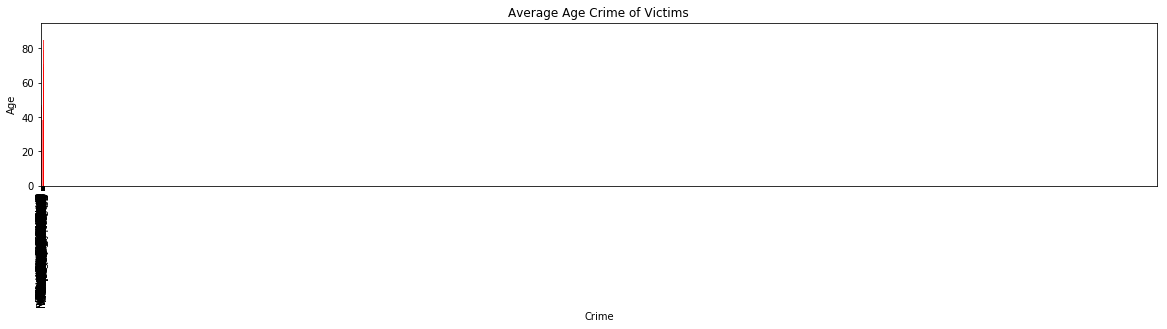

In [39]:
# plt.tight_layout()
# plt.savefig("avg_state_rain.png")
plt.show()

### Confirming Clean Data in Excel

In [18]:
# kc_crime_close.to_csv('kc_crime_close.csv', index=False)

# Confirm above data is good before proceeding

### Apply get_dummies function

In [21]:
crime_columns = pd.get_dummies(kc_crime_close['Crime'],prefix = "Crime")
kc_crime_close = pd.concat([kc_crime_close, crime_columns], axis=1)
kc_crime_close.drop('Crime', axis=1, inplace=True)
zip_columns = pd.get_dummies(kc_crime_close['Zip'],prefix = "Zip")
kc_crime_close = pd.concat([kc_crime_close, zip_columns], axis=1)
kc_crime_close.drop('Zip', axis=1, inplace=True)
race_columns = pd.get_dummies(kc_crime_close['Race'],prefix = "Race")
kc_crime_close = pd.concat([kc_crime_close, race_columns], axis=1)
kc_crime_close.drop('Race', axis=1, inplace=True)
sex_columns = pd.get_dummies(kc_crime_close['Sex'],prefix = "Sex")
kc_crime_close = pd.concat([kc_crime_close, sex_columns], axis=1)
kc_crime_close.drop('Sex', axis=1, inplace=True)
age_columns = pd.get_dummies(kc_crime_close['Age'],prefix = "Age")
kc_crime_close = pd.concat([kc_crime_close, age_columns], axis=1)
kc_crime_close.drop('Age', axis=1, inplace=True)
date_columns = pd.get_dummies(kc_crime_close['Date'],prefix = "Date")
kc_crime_close = pd.concat([kc_crime_close, date_columns], axis=1)
kc_crime_close.drop('Date', axis=1, inplace=True)
hour_columns = pd.get_dummies(kc_crime_close['Hour'],prefix = "Hour")
kc_crime_close = pd.concat([kc_crime_close, hour_columns], axis=1)
kc_crime_close.drop('Hour', axis=1, inplace=True)

In [22]:
kc_crime_close.head()

,Report,Latitude,Longitude,Crime_Agg Assault - Domest,Crime_Agg Assault - Drive-,Crime_Aggravated Assault,Crime_Aggravated Assault (,Crime_Armed Robbery,Crime_Arson,Crime_Arson with Fire Bomb,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,100080848,39.053635,-94.595998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,120046817,39.10091,-94.577328,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,160028258,39.17744,-94.572069,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,160034107,39.033505,-94.547812,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,160063139,39.235881,-94.466171,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
